In [ ]:
!nvidia-smi

Tue Sep 21 18:08:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    89W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

NameError: ignored

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
# import json
# PATH = "/content/drive/MyDrive/NLP/"
# f = open(PATH + "multiple_choice_92sim.json",)
# data = json.load(f)

# print(len(data))
# f.close()

In [ ]:
# import json
# PATH = "/content/drive/MyDrive/Colab Notebooks/NLP/"
# f = open(PATH + "multiple_choice_92sim.json",)
# data = json.load(f)

# print(len(data))
# f.close()

In [ ]:
# import json
# PATH = "/content/drive/MyDrive/Colab Notebooks/NLP/"
# f = open(PATH + "labeled_pairs_3_15.json",)
# data_2 = json.load(f)

# print(len(data_2))
# f.close()

In [2]:
from sklearn.model_selection import train_test_split

In [ ]:
# train_texts, test_texts = train_test_split(data, test_size=.1)
# with open(PATH + 'data/train.json', 'w') as f:
#   json.dump(train_texts, f)

# with open(PATH + 'data/test.json', 'w') as f:
#   json.dump(test_texts, f)

In [ ]:
# DATAPATH = PATH + 'data/train.json'
# def get_data(path=DATAPATH):

#   question_list = list()
#   expo_list = list()

#   with open(DATAPATH) as f:
#     data = list(json.load(f))
  
#   for question, expo in data:
#     question_list.append(question)
#     expo_list.append(expo[0])

#   return question_list, expo_list

In [3]:
import json
from tqdm.notebook import tqdm

In [4]:
PATH = "/content/drive/MyDrive/ReverseQA"
DATAPATH = PATH + "/processed_data/train.json"
def get_data(path=DATAPATH):

  question_list = list()
  answer_list = list()

  with open(DATAPATH) as f:
    for line in f:
      data = json.loads(line)
      question_list.append(data['question'])
      answer_list.append(data['answer'])


  return question_list[0:1000], answer_list[0:1000]

In [5]:
#DATAPATH = PATH + 'data/clean_train.json'
PATH = "/content/drive/MyDrive/ReverseQA"
DATAPATH = PATH + '/processed_data/valid_filtered_qa_pairs.json'
def get_data(path=DATAPATH):

  question_list = list()
  expo_list = list()

  with open(DATAPATH) as f:
    data = list(json.load(f))
    if [] in data:
      data.remove([])
  
  for question, expo in data:
    question_list.append(question)
    expo_list.append(expo[0])

  return question_list[:100], expo_list[:100]

In [6]:
question_list, answer_list = get_data()

In [40]:
answer_list[0]

"Well, international JV and partnerships are incredibly important to our customers. They are a way to give a seamless experience to our customers, to get them around the world. This is one of those rare events that if they win, win, win; it's a win for United Airlines. It could be a win for our partners, and it's absolutely a win for our customers.\nI think we -- and Star Alliance, we all believe that we have an opportunity to do better. We can be more seamlessly integrated with one another and that includes on the commercial front, but to a large degree, that includes the customer experience, where we can make the experience more seamless.\nAnd we have a new CEO at Star Alliance, and that is his number one mission. I'll actually be going to the Star Alliance meeting on Mother's Day, which my wife doesn't appreciate, but it's in Germany. And the focus of the meeting is to talk about how we can create a more seamless experience for our customers and really have the focus to be on custom

In [ ]:
!pip install transformers

In [7]:
import torch
import transformers
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, length):
        self.encodings = encodings
        self.labels = labels
        self.length = length

    def __getitem__(self, idx):
        encoding_item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        label_item = {key: torch.tensor(val[idx]) for key, val in self.labels.items()}
        return encoding_item, label_item

    def __len__(self):
        return self.length

def get_dataset(answer_list,question_list):
    from sklearn.model_selection import train_test_split
    #from transformers import BartTokenizerFast
    from transformers import BertTokenizer

    train_es, val_es, train_qs, val_qs = train_test_split(answer_list,question_list, test_size=.1)

    #tokenizer = BartTokenizerFast.from_pretrained('facebook/bart-base')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


    train_q_encodings = tokenizer(train_qs, truncation=True, padding=True)
    val_q_encodings = tokenizer(val_qs, truncation=True, padding=True)

    train_e_encodings = tokenizer(train_es, truncation=True, padding=True)
    val_e_encodings = tokenizer(val_es, truncation=True, padding=True)

    train_dataset = IMDbDataset(train_e_encodings,train_q_encodings, length = len(train_qs))
    val_dataset = IMDbDataset(val_e_encodings, val_q_encodings, length=len(val_qs))

    return train_dataset, val_dataset

In [8]:
train_dataset, val_dataset = get_dataset(answer_list,question_list)

In [9]:
print(len(train_dataset))

90


In [10]:
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss

from torch.utils.data import DataLoader
#from transformers import BartForConditionalGeneration, AdamW
from transformers import AdamW
from transformers import BertGenerationEncoder, BertGenerationDecoder, BertTokenizer, EncoderDecoderModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

#model =  BartForConditionalGeneration.from_pretrained('facebook/bart-base')
encoder = BertGenerationEncoder.from_pretrained('bert-base-uncased')
decoder = BertGenerationDecoder.from_pretrained('bert-base-uncased', add_cross_attention=True, is_decoder = True)
model = EncoderDecoderModel(encoder=encoder, decoder=decoder)

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

You are using a model of type bert to instantiate a model of type bert-generation. This is not supported for all configurations of models and can yield errors.


True
cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertGenerationEncoder: ['cls.predictions.transform.dense.weight', 'bert.pooler.dense.bias', 'cls.predictions.decoder.weight', 'bert.embeddings.token_type_embeddings.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertGenerationEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertGenerationEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You are using a m

In [11]:
WEIGHT_PATH = PATH + '/weights/generation_clean_bert2'

In [12]:
def train(epochs=10):
    train_loss_set = list()
    for epoch in tqdm(range(epochs)):
        for batch in train_loader:
            input, label = batch

            optim.zero_grad()

            input_ids = input['input_ids'].to(device)
            attention_mask = input['attention_mask'].to(device)

            labels = label['input_ids'].to(device)
            outputs = model(input_ids = input_ids, attention_mask=attention_mask, decoder_input_ids=labels, labels=labels)
            loss = outputs[0]
            # loss_func = BCEWithLogitsLoss()
            # loss = loss_func(logits, labels)  # convert labels to float for calculation
            # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
            train_loss_set.append(loss.item())

            # Backward pass
            loss.backward()

            optim.step()

        print("Finished epoch {}".format(epoch))

    model.save_pretrained(WEIGHT_PATH)
    return train_loss_set

  0%|          | 0/20 [00:00<?, ?it/s]

Finished epoch 0
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Finished epoch 6
Finished epoch 7
Finished epoch 8
Finished epoch 9
Finished epoch 10
Finished epoch 11
Finished epoch 12
Finished epoch 13
Finished epoch 14
Finished epoch 15
Finished epoch 16
Finished epoch 17
Finished epoch 18
Finished epoch 19


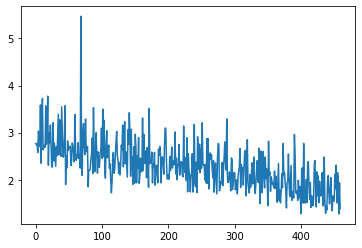

In [14]:
loss_values = train(20)

import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.show()

In [15]:
#model = BartForConditionalGeneration.from_pretrained(WEIGHT_PATH)
model = EncoderDecoderModel.from_pretrained(WEIGHT_PATH)
model.to(device)

EncoderDecoderModel(
  (encoder): BertGenerationEncoder(
    (embeddings): BertGenerationEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (d

In [16]:
#DATAPATH = PATH + 'data/clean_test.json'
DATAPATH = PATH + "/processed_data/test.json"
import torch
#from transformers import BartTokenizerFast
#tokenizer = BartTokenizerFast.from_pretrained('facebook/bart-base')
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def get_data(path=DATAPATH):

  question_list = list()
  answer_list = list()

  with open(DATAPATH) as f:
    for line in f:
      data = json.loads(line)
      question_list.append(data['question'])
      answer_list.append(data['answer'])


  return question_list[0:200], answer_list[0:200]
class TestDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, expos, labels, length):
      self.encodings = encodings
      self.expos = expos
      self.labels = labels
      self.length = length

  def __getitem__(self, idx):
      encoding_item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      return (encoding_item, self.labels[idx], self.expos[idx])

  def __len__(self):
      return self.length

def get_dataset(question_list, expo_list):

  expo_encodings = tokenizer(expo_list, truncation=True, padding=True)

  test_dataset = TestDataset(expo_encodings, expo_list, question_list,length = len(question_list))

  return test_dataset

In [17]:
question_list, expo_list = get_data()
test_dataset = get_dataset(question_list, expo_list)

In [ ]:
!pip install datasets

In [ ]:
!pip install bert_score

In [ ]:
#from transformers import datasets
from datasets import load_metric 
metric = load_metric("bertscore")


In [18]:
#from transformers import BartForConditionalGeneration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

def validate(val_dataset):
    #model =  BartForConditionalGeneration.from_pretrained(WEIGHT_PATH)
    model = EncoderDecoderModel.from_pretrained(WEIGHT_PATH)
    model.to(device)
    model.eval()

    val_loader = DataLoader(val_dataset, batch_size=5, shuffle=True)

    print("Evaluating on {} questions".format(len(val_dataset)))

    list_of_references = list()
    list_of_hypotheses = list()
    list_of_original = list()
    list_of_pp = list()

    count = 0
    for batch in val_loader:
        input, label, orig = batch
        input_ids = input['input_ids'].to(device)
        attention_mask = input['attention_mask'].to(device)

        with torch.no_grad():
            output = model.generate(
                #decoder_input_ids=decoder_input_ids,
                input_ids=input_ids,
                # do_sample=True,
                # max_length=600,
                # temperature=1.0,
                # top_k=5,
                # top_p=0.9,
                # repetition_penalty=1.0,
                )
            #print(generated_sequences)
            #print(label)
            reference = label[0].split()

            text = tokenizer.decode(output[0], clean_up_tokenization_spaces=True)
            #hypothesis = text.split()
            '''
            if text != '</s>' or text != '<s>' or text != '<pad>':
              hypothesis += text
            '''
            text = text.replace('</s>', '')
            text = text.replace('<s>', '')
            text = text.replace('<pad>', '')

            hypothesis = text.split()
            #print(text)

            #perplexity
            # token = tokenizer(text, return_tensors='pt')
            # ppl = get_ppl(token)

            #print(pp_score)
            # list_of_pp.append(ppl)
            # Prints out sequences
            #print(hypothesis)

            list_of_hypotheses.append(hypothesis)
            list_of_references.append([reference])
            list_of_original.append(orig)
        print(count)
        count += 1
            
    # Calculate BLEU Score
    import nltk
    score = nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses)

    return list_of_references, list_of_hypotheses,list_of_original, score, list_of_pp
      # import torchtext

      #   score = torchtext.data.metrics.bleu_score(candidate_corpus, references_corpus)

In [19]:
def get_ppl(encodings):
  max_length = 600
  stride = 300

  lls = []
  for i in range(0, encodings.input_ids.size(1), stride):
      begin_loc = max(i + stride - max_length, 0)
      end_loc = min(i + stride, encodings.input_ids.size(1))
      trg_len = end_loc - i    # may be different from stride on last loop
      input_ids = encodings.input_ids[:,begin_loc:end_loc].to(device)
      target_ids = input_ids.clone()
      target_ids[:,:-trg_len] = -100

      with torch.no_grad():
          outputs = model(input_ids, labels=target_ids)
          log_likelihood = outputs[0] * trg_len

      lls.append(log_likelihood)

  ppl = torch.exp(torch.stack(lls).sum() / end_loc)
  return ppl

In [20]:
list_of_references, list_of_hypotheses, list_of_original, score, list_of_pp = validate(test_dataset)

Evaluating on 200 questions
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [ ]:
print(len(list_of_pp))

0


In [21]:
from pprint import pprint

In [22]:
#list_of_references, list_of_hypotheses, list_of_original, score, list_of_pp = validate(test_dataset)
for i in range(0,10):
  pprint(list_of_references[i][0])
  print('------------------------------------------------')
  pprint(list_of_hypotheses[i])
  print('------------------------------------------------')
  pprint(list_of_original[i])
  print("================================================")

['Okay.',
 'And',
 'then,',
 'finally,',
 'John,',
 'in',
 'the',
 'press',
 'release',
 'you',
 'mentioned',
 'Okay.',
 'And',
 'finally',
 'John,',
 'in',
 'the',
 'press',
 'release',
 'you',
 'mentioned',
 'kind',
 'of',
 'a',
 'reorganization',
 'of',
 'some',
 'international',
 'offices',
 'that',
 'you',
 'had.']
------------------------------------------------
['[unused1]',
 'i',
 'think',
 'you',
 'could',
 'to',
 'be',
 'a',
 'little',
 'bit',
 'of',
 'the',
 'year,',
 'i',
 'think',
 'you',
 'could',
 'talk',
 'about']
------------------------------------------------
('Yes.',
 "Well, we have our own – it's hard to answer that, specifically. If you're "
 'asking that is the exact changes and exact spacing going from a Gen 4 in the '
 'Marcellus to a Gen 5 in the Marcellus, is that going to transfer to the '
 'Eagle Ford? And is the fluid pumped in a Gen 4 Marcellus to a Gen 5 '
 'Marcellus, is that the exact fluid that we pump going to transfer to the '
 'Eagle Ford? The answ

In [23]:
print(score)

0.0037410494919325977


In [24]:
from datasets import load_metric
import bert_score
metric = load_metric("bertscore")

In [25]:
lis_of_h = []
lis_of_r = []
for i in tqdm(range(len(list_of_hypotheses))):
  h = list_of_hypotheses[i][0]
  r = ' '.join(list_of_references[i][0])
  lis_of_h.append(h)
  lis_of_r.append(r)

  0%|          | 0/40 [00:00<?, ?it/s]

In [26]:
P, R, F1 = bert_score.score(lis_of_h, lis_of_r, lang='en', verbose=True)


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.69 seconds, 23.64 sentences/sec


In [27]:
print(F1)
print(f"System level F1 score: {F1.mean():.3f}")
print(f"System level Precision: {P.mean():.3f}")
print(f"System level Recall: {R.mean():.3f}")

tensor([0.7847, 0.7752, 0.7993, 0.7738, 0.7733, 0.7896, 0.7762, 0.7804, 0.7673,
        0.7836, 0.7724, 0.7894, 0.7779, 0.7823, 0.7750, 0.7853, 0.7747, 0.8018,
        0.7928, 0.7835, 0.7821, 0.7749, 0.7671, 0.7691, 0.8144, 0.7900, 0.7733,
        0.7757, 0.7827, 0.7720, 0.7888, 0.7747, 0.7746, 0.8028, 0.7948, 0.7813,
        0.7684, 0.7776, 0.7813, 0.7764])
System level F1 score: 0.782
System level Precision: 0.780
System level Recall: 0.783


In [ ]:
print(list_of_pp[0].item())

IndexError: ignored

In [ ]:
sum = 0
for i in range(len(list_of_pp)):
  sum += list_of_pp[i].item()
print(sum/300)

1.758521210749944


In [ ]:
from tqdm.notebook import tqdm
model =  BartForConditionalGeneration.from_pretrained(WEIGHT_PATH)
model.to(device)
generated_sen = []

for i in tqdm(range(0,3441)):
  sentence = data[i][1][0]
  tokenize_input = tokenizer.tokenize(sentence)
  tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)]).to(device)
  a = model.generate(tensor_input,
                do_sample=True,
                max_length=600,
                temperature=1.0,
                top_k=5,
                top_p=0.9,
                repetition_penalty=1.0,
                )
  text = ''
  for w in a:
    text += tokenizer.decode(w, clean_up_tokenization_spaces=True)
  generated_sen.append(text)
  #print(text)
'''
import json
PATH = "/content/drive/MyDrive/Colab Notebooks/NLP/"
f = open(PATH + "generated_sentences.json",'w')
json.dump(generated_sen, f)

f.close()
'''

In [ ]:
print(len(generated_sen))

3441


In [ ]:
print(generated_sen[7])

</s><s>Hi, good morning. Thanks for taking my question. I wanted to follow-up on OptumInsight’s operating margin guidance. So, you’re guiding to about 25% operating margin in fiscal ‘19. You’ve got OptumRx now at 20%, OptumNow at 20%. So, I’m just trying to get a sense of how much of that is coming from Optum insight versus Optum Insight? And then, my second question is just around the Optum business. I think, historically, Optum has been in the mid-single-digit operating margin range for a couple of years, but now, you are moving closer to the upper end of that range. And I was just wondering if you could give us a little bit more color on what you think is driving that relative to your long-term target of 30% to 40% operating margins? Thank you.</s>


In [ ]:
print(list_of_pp)

[tensor(3123.8684, device='cuda:0'), tensor(722.2648, device='cuda:0')]


In [ ]:
print(score)

0


In [ ]:
from pprint import pprint

In [ ]:
for i in range(len(list_of_references)):
  print("Original:")
  print(list_of_original[i])
  print("Ground Truth:")
  print(' '.join(list_of_references[i][0]))
  print("Generated: ")
  print(list_of_hypotheses[i])
  print("-------------------------------")

In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from tqdm.notebook import tqdm
device = 'cuda:0'
model_id = 'gpt2-large'
gpt_model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

KeyboardInterrupt: ignored

In [ ]:
import math
import torch
!pip install pytorch_pretrained_bert
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel, OpenAIGPTLMHeadModel
# Load pre-trained model (weights)
model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
model.eval()
# Load pre-trained model tokenizer (vocabulary)
tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')

     |████████████████████████████████| 133kB 12.0MB/s 
     |████████████████████████████████| 133kB 20.3MB/s 
     |████████████████████████████████| 81kB 6.7MB/s 
     |████████████████████████████████| 7.3MB 18.5MB/s 
ERROR: botocore 1.20.35 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


100%|██████████| 458495/458495 [00:00<00:00, 1281637.38B/s]
ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [ ]:
def score(sentence):
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    loss=model(tensor_input, lm_labels=tensor_input)
    return math.exp(loss)

a = ["i wrote a book, i wrote a book, i wrote a book, i wrote a book,i wrote a book, i wrote a book.",
   "i wrote a book.",
   "i wrote a book about the life of two young people who fall in love with each other."]
     
print([score(i) for i in a])

TypeError: ignored

In [ ]:
def pp_score(model, sentence,  mask_token_id=103):
  tensor_input = sentence
  repeat_input = tensor_input.repeat(tensor_input.size(-1)-2, 1)
  mask = torch.ones(tensor_input.size(-1) - 1).diag(1)[:-2]
  masked_input = repeat_input.masked_fill(mask == 1, 103)
  labels = repeat_input.masked_fill( masked_input != 103, -100)
  loss,_ = model(masked_input, masked_lm_labels=labels)
  result = np.exp(loss.item())
  return result